# SBI: Priors and preparation

Here, a deep neural estimator is trained to provide a relationship between the parameters of a model (black box simulator) and selected descriptive statistics of the observed data.

The procedure is split into following steps:
1. Simulations using parameters drawn from the prior distributions
2. Training the deep neural estimator
3. Computing the posterior density with respect to the empirical observables.


In this notebook we perform the first step.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from tvb.simulator.lab import *

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [4]:
from tvb_inversion.sbi import Prior
from tvb_inversion.sbi import EstimatorSBI

In [5]:
from tvb_inversion.utils import data_path, run_local
from tvb_inversion.parameters import SimSeq
from tvb_inversion.sbi.demo import BoldFCDForSBI
from tvb.simulator.backend.nb_mpr import NbMPRBackend

The simulation is defined by the TVB `Simulator` instance, for local and cluster execution we need a function which prepares it for us given the values of parameters.

In [15]:
conn = connectivity.Connectivity.from_file(data_path('demo_connectivity.zip'))

sim = simulator.Simulator(
    model=models.MontbrioPazoRoxin(
        eta=np.r_[-4.6],
        J=np.r_[14.5],
        Delta=np.r_[0.7],
        tau=np.r_[1],
    ),
    connectivity=conn,
    coupling=coupling.Linear(
        a=np.r_[2.45]
    ),
    conduction_speed=conn.speed.item(),
    integrator=integrators.HeunStochastic(
        dt=0.01,
        noise=noise.Additive(
            nsig=np.r_[0.035, 0.035 * 2],
            noise_seed=42
        )
    ),
    monitors=[monitors.TemporalAverage(period=0.1)],
    simulation_length=3e3 # decreased for demo purposes
)

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Now we define the prior distribution over the parameters. Here, it is just a one-dimensional prior on single prior over the parameter `coupling.a`. The `Distribution` can be any class supporting the `.sample` and `.log_prob()` methods, e.g. the PyTorch distribution. Just make sure the dimension of each sample is equal the number of parameters (here 1). See docs on examples for scenarios with multiple parameters.

In [16]:
prior = Prior(['coupling.a'], torch.distributions.Uniform(0.1, 1.2))
prior

['coupling.a'], Uniform(low: 0.10000000149011612, high: 1.2000000476837158)

We can now sample from the prior to get the sequence of simulations we need to execute (we can also save this for later re-use etc.). Here, for demonstration purposes we choose a very low number of four. In realistic scenarios, one has to run thousands of simulations from the prior.

In [17]:
seq = prior.generate_sim_seq(sim, 4)

In [18]:
import matplotlib.pylab as plt

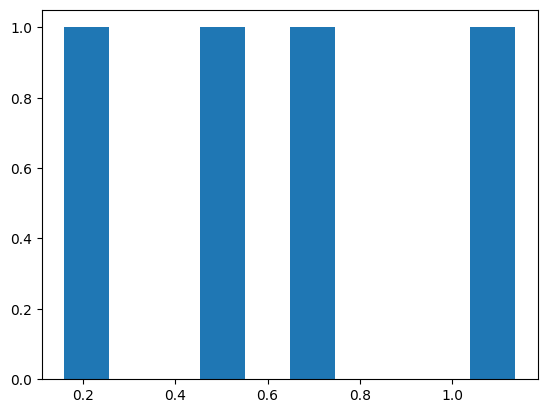

In [19]:
params = np.array(seq.values).squeeze()
plt.hist(params);

Next we need to define the summary statistics to be extracted from the simulated time-series. Custom metrics can be defined and wrapped in the callable `parameters.Metric`. Here we use the pre-defined example `demo.BoldFCDForSBI` which computes bold signal from the provided time-average time series and a set of useful metrics such as variability of functional connectivity dynamics and others.

Executing the large number of simulations can take a long time, here we perform local parallel execution, see docs for distributed execution examples.

In [20]:
metrics = [BoldFCDForSBI(win_len=3)]
run_local(seq, metrics, backend=NbMPRBackend, checkpoint_dir='test_run', filename='results.npy')

/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/home/izaak/local_repos/megaloceros/tvb-inversion/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


When the simulations are done, we can extract the summary statistics with the following code. 

In [21]:
estimator = EstimatorSBI(prior, seq=seq, metrics=metrics)

In [22]:
summ_stats = estimator.load_summary_stats('results.npy')
summ_stats

,HOMO_FC,FCD_STACK_STD_INTER_TENS,FCD_SUBJ_DIFF_VAR_OV_TENS,FC_SUM,FCD_SUM
0,0.807541,0.383083,0.038413,4954.442188,6.866754
1,0.801354,0.398649,0.045623,4374.792280,5.232227
2,0.818952,0.395458,0.040640,5664.164392,3.097200
3,NaN,NaN,NaN,NaN,NaN


The last simulation didn't converge (numerical issues), so we can either remove that sample, or re-run that point with smaller integration dt. 

In the next notebook we pick up the workflow with precomputed samples.